<a href="https://colab.research.google.com/github/surajjeoor/Human_vs_machine_68/blob/main/GPTZero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2LMHeadModel,GPT2TokenizerFast
model_id="gpt2"
device="cuda"

model=GPT2LMHeadModel.from_pretrained(model_id)
tokenizer=GPT2TokenizerFast.from_pretrained(model_id)

In [ ]:
import torch

In [ ]:
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


In [ ]:
model=model.to(device)

In [ ]:
print(device)

cuda


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
df=pd.read_excel("/content/English_Data_Train_one_topic.xlsx")

In [ ]:
df.head(5)

,id,title,text,Generated By,labels
0,1,Chatrapati Shivaji Maharaj,Shivaji Maharaj's coronation took place in a g...,Machine,0
1,2,Chatrapati Shivaji Maharaj,He built a strong network of hill forts and co...,Machine,0
2,3,Chatrapati Shivaji Maharaj,"Several forts, statues, and monuments dedicate...",Machine,0
3,4,Chatrapati Shivaji Maharaj,"Throughout Maharashtra and other regions, stat...",Machine,0
4,5,Chatrapati Shivaji Maharaj,Shivaji escaped from Panhala by cover of night...,Human,1


In [ ]:
df=df.dropna()

In [ ]:
df['Id']=df['Id'].astype(int)
df['Class']=df['Class'].astype(int)

In [ ]:
df.head(5)

,id,title,text,Generated By,labels
0,1,Chatrapati Shivaji Maharaj,Shivaji Maharaj's coronation took place in a g...,Machine,0
1,2,Chatrapati Shivaji Maharaj,He built a strong network of hill forts and co...,Machine,0
2,3,Chatrapati Shivaji Maharaj,"Several forts, statues, and monuments dedicate...",Machine,0
3,4,Chatrapati Shivaji Maharaj,"Throughout Maharashtra and other regions, stat...",Machine,0
4,5,Chatrapati Shivaji Maharaj,Shivaji escaped from Panhala by cover of night...,Human,1


In [ ]:
import re
from collections import OrderedDict
import torch
from tqdm import tqdm

In [ ]:
"""
The below code is taken and slightly modified from : https://github.com/BurhanUlTayyab/GPTZero/blob/main/model.py
"""
class GPT2_model_ppl:
  def __init__(self,model1,tok1,device1="cuda"):
    self.device=device1
    self.model=model1.to(device1)
    self.tokenizer=tok1

    self.max_length=self.model.config.n_positions
    self.stride=512

  def GetResults(self,threshold):
    if threshold < 60:
      return 0
    elif threshold < 80:
      return 0
    else:
      return 1

  def __call__(self, sentence):
    results=OrderedDict()
    total_valid_char=re.findall(r'[a-zA-Z0-9ÄÖÜäöüß]',sentence)
    total_valid_char=sum([len(x)for x in total_valid_char])

    if total_valid_char<20:
      return {"Status":"Please input more than 20 characters"},"Please input more text"

    lines=re.split(r'(?<=[.?!][ \[\(])|(?<=\n)\s*',sentence)
    lines=list(filter(lambda x : (x is not None)and(len(x)>0),lines))

    ppl=self.getPPL(sentence)
    print(f"Perplexity : {ppl}")
    results["Perplexity"]=ppl

    offset=""

    Perplexity_per_line=[]

    for i,line in enumerate(lines):
      if re.search(r'[a-zA-Z0-9ÄÖÜäöüß]',line)==None:
        continue

      if len(offset)>0:
        line=offset+line
        offset=""
      if line[0]=="\n" or line[0]==" ":
        line=line[1:]
      if line[-1]=="\n" or line[-1]==" ":
        line=line[:-1]
      elif line[-1]=="[" or line[-1]=="(":
        offset=line[-1]
        line=line[:-1]
      ppl=self.getPPL(line)
      Perplexity_per_line.append(ppl)

    if len(Perplexity_per_line)!=0:
      results["Perplexity_perline"]=sum(Perplexity_per_line)/len(Perplexity_per_line)
      results["Burstiness"]=max(Perplexity_per_line)
      label=self.GetResults(results["Perplexity_perline"])
    else:
      label=0
    print("Average perplexity:",results["Perplexity_perline"])
    return label

  def getPPL(self,sentence):
    encodings = self.tokenizer(sentence, return_tensors="pt")
    seq_len = encodings.input_ids.size(1)

    nlls = []
    likelihoods = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, self.stride):
        end_loc = min(begin_loc + self.max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(self.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = self.model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len
            likelihoods.append(neg_log_likelihood)

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    x=torch.exp(torch.stack(nlls).sum() / end_loc)
    if(x==None):
                ppl=0
    else:
                ppl =int(x)

    return ppl



In [ ]:

model1=GPT2_model_ppl(model1=model,device1=device,tok1=tokenizer)

# x=model1(sentence)

In [ ]:
sentence="""Adolf Hitler (1889-1945) war ein deutscher Politiker und der Führer der Nationalsozialistischen Deutschen Arbeiterpartei (NSDAP), allgemein bekannt als die Nazi-Partei. Er kam 1933 als Reichskanzler an die Macht und wurde später zum Diktator des nationalsozialistischen Deutschlands von 1934 bis 1945.

Hitlers politische Ideologie, bekannt als Nationalsozialismus, war gekennzeichnet durch extremen Nationalismus, Rassismus und Antisemitismus. Er glaubte an die Überlegenheit der arischen Rasse und förderte das Konzept des Lebensraums, das eine territoriale Expansion zur Unterbringung der deutschen Bevölkerung vorsah. Hitlers Verfolgung dieser Ideen führte zum Zweiten Weltkrieg und zum Holocaust, bei dem Millionen von Menschen starben, darunter sechs Millionen Juden im systematischen Völkermord.

Unter Hitlers Führung durchlief Deutschland eine erhebliche Transformation. Er setzte Maßnahmen zur Machtkonsolidierung, Unterdrückung der Opposition und Kontrolle aller Aspekte der deutschen Gesellschaft um. Hitlers Regierung erließ repressive Maßnahmen, die sich gegen politische Dissidenten, Minderheitengruppen und Personen richteten, die vom Nazi-Regime als unerwünscht angesehen wurden.

Die Kriegsstrategien, die von Hitler und seinen Generälen eingesetzt wurden, brachten anfangs militärischen Erfolg für Deutschland, aber letztendlich wurden sie besiegt, als die alliierten Streitkräfte die Wende gegen die Nazis herbeiführten. Im April 1945, als die Rote Armee der Sowjetunion Berlin belagerte, zog sich Hitler in seinen Bunker zurück und beging am 30. April gemeinsam mit seiner Frau Eva Braun Selbstmord.

Adolf Hitlers Erbe bleibt aufgrund des immensen Leidens und der Zerstörung, die sein Regime verursacht hat, in schändlicher Erinnerung. Seine Handlungen während seiner Zeit an der Macht dienen weiterhin als deutliche Mahnung an die Konsequenzen ungezügelten Extremismus und die Bedeutung des Schutzes von Menschenrechten und demokratischen Prinzipien."""
x1=model1(sentence)
x1

Perplexity : 57
Average perplexity: 133.30769230769232


1

In [ ]:
H_M=[]
for sent in df["text"]:
  x=model1(sent)
  H_M.append(x)

Perplexity : 35
Average perplexity: 59.5
Perplexity : 54
Average perplexity: 67.5
Perplexity : 12
Average perplexity: 22.0
Perplexity : 24
Average perplexity: 24.0
Perplexity : 74
Average perplexity: 74.0
Perplexity : 36
Average perplexity: 43.5
Perplexity : 33
Average perplexity: 109.0
Perplexity : 30
Average perplexity: 82.33333333333333
Perplexity : 37
Average perplexity: 79.66666666666667
Perplexity : 33
Average perplexity: 57.5
Perplexity : 25
Average perplexity: 46.5
Perplexity : 32
Average perplexity: 42.5
Perplexity : 52
Average perplexity: 59.5
Perplexity : 28
Average perplexity: 36.0
Perplexity : 19
Average perplexity: 35.666666666666664
Perplexity : 36
Average perplexity: 76.66666666666667
Perplexity : 26
Average perplexity: 41.0
Perplexity : 71
Average perplexity: 110.5
Perplexity : 27
Average perplexity: 53.5
Perplexity : 39
Average perplexity: 118.25
Perplexity : 24
Average perplexity: 27.5
Perplexity : 24
Average perplexity: 169.25
Perplexity : 119
Average perplexity: 18

In [ ]:
len(H_M)

50

In [ ]:
len(df)

50

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
import evaluate

clf_metrics=evaluate.combine(["accuracy","f1","precision","recall"])

In [ ]:
ref_list=list(df['labels'])

In [ ]:
clf_metrics.compute(predictions=H_M,references=ref_list)

{'accuracy': 0.68,
 'f1': 0.5789473684210527,
 'precision': 0.7857142857142857,
 'recall': 0.4583333333333333}

In [ ]:
cm=confusion_matrix(ref_list,H_M)

In [ ]:
display1=ConfusionMatrixDisplay(confusion_matrix=cm)

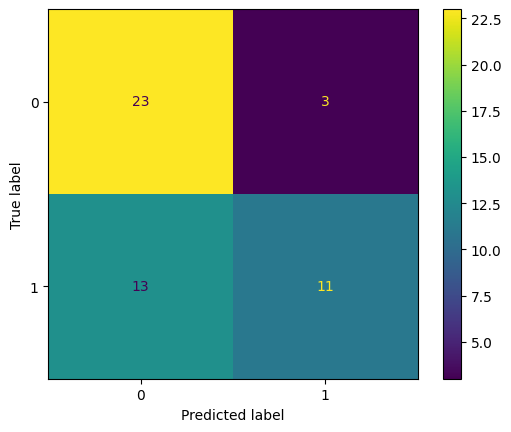

In [ ]:
display1.plot()